In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Speech_Emotion/RAVDESS.csv')
uniq=list(pd.unique(df['Label']))
id2label={uniq.index(i):i for i in uniq}
label2id={id2label[ind]:ind for ind in id2label.keys()}
id2label={0:'neutral',1:'calm',2:'happy',3:'sad',4:'angry',5:'fearful',6:'disgust',7:'surprised'}
label2id={id2label[ind]:ind for ind in id2label.keys()}

In [ ]:
import librosa
def get_feature(file_path: str, mfcc_len: int = 39, mean_signal_length: int = 100000):
  """
  file_path: Speech signal folder
  mfcc_len: MFCC coefficient length
  mean_signal_length: MFCC feature average length
  """
  signal, fs = librosa.load(file_path)
  s_len = len(signal)

  if s_len < mean_signal_length:
      pad_len = mean_signal_length - s_len
      pad_rem = pad_len % 2
      pad_len //= 2
      signal = np.pad(signal, (pad_len, pad_len + pad_rem), 'constant', constant_values = 0)
  else:
      pad_len = s_len - mean_signal_length
      pad_len //= 2
      signal = signal[pad_len:pad_len + mean_signal_length]
  mfcc = librosa.feature.mfcc(y=signal, sr=fs, n_mfcc=39)
  mfcc = mfcc.T
  feature = mfcc
  return feature

In [ ]:
features=get_feature(df['Path'].iloc[0])

In [ ]:
print(features.shape)

(196, 39)


In [ ]:
training_args={
    'mode':'train',
    'lr':0.001,
    'activation':'relu',
    'epoch':3,
    'dropout_rate':0.1,
    'filter_size':39,
    'dialation_size':8,
    'kernel_size':2,
    'return_sequences':True,
    'nb_stack':15,
    'nb_filter':64
}

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.layers import Conv1D, SpatialDropout1D,add,GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import sigmoid

class Temporal_Aware_Block(tf.keras.layers.Layer):
  #Temporal Aware Block
  def __init__(self,s, i, activation, nb_filters, kernel_size, dropout_rate=0):
    super().__init__()
    self.conv1=Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')
    self.conv2=Conv1D(filters=nb_filters, kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')
    self.bn1=BatchNormalization(trainable=True,axis=-1)
    self.bn2=BatchNormalization(trainable=True,axis=-1)
    self.ac1=Activation(activation)
    self.ac2=Activation(activation)
    self.d1=SpatialDropout1D(dropout_rate)
    self.d2=SpatialDropout1D(dropout_rate)
    self.nb_filters=nb_filters
  def compute_output_shape(self,input_shape):
    return (1,self.nb_filters)
  def call(self,x):
    original_x = x
    #1.1
    conv_1_1 = self.conv1(x)
    conv_1_1 = self.bn1(conv_1_1)
    conv_1_1 =  self.ac1(conv_1_1)
    output_1_1 =  self.d1(conv_1_1)
    # 2.1
    conv_2_1 = self.conv2(output_1_1)
    conv_2_1 = self.bn2(conv_2_1)
    conv_2_1 = self.ac2(conv_2_1)
    output_2_1 =  self.d2(conv_2_1)

    if original_x.shape[-1] != output_2_1.shape[-1]:
        original_x = Conv1D(filters=self.nb_filters, kernel_size=1, padding='same')(original_x)

    output_2_1 = Lambda(sigmoid)(output_2_1)
    F_x = Lambda(lambda x: tf.multiply(x[0], x[1]))([original_x, output_2_1])
    return F_x

class WeightLayer(tf.keras.layers.Layer):
    #Creates layers for each TAB block
    def __init__(self, **kwargs):
        super(WeightLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[1],1),
                                      initializer='uniform',
                                      trainable=True)
        super(WeightLayer, self).build(input_shape)

    def call(self, x):
        tempx = tf.transpose(x,[0,2,1])
        x = K.dot(tempx,self.kernel)
        x = tf.squeeze(x,axis=-1)
        return  x

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])

class TIMNET(tf.keras.layers.Layer):
    def __init__(self,num_labels,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=8,
                 activation = "relu",
                 dropout_rate=0.1,
                 return_sequences=True):
      super().__init__()
      #Responsible for formulation of TIMNET architecture using TAB blocks
      self.flatten = tf.keras.layers.Flatten()
      self.return_sequences = return_sequences
      self.activation = activation
      self.dropout_rate = dropout_rate
      self.dialations = dilations
      self.nb_stacks = nb_stacks
      self.kernel_size = kernel_size
      self.nb_filters = nb_filters

      self.supports_masking = True
      self.mask_value=0.
      self.num_labels=num_labels

      self.conv1=Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')
      self.conv2=Conv1D(filters=self.nb_filters,kernel_size=1, dilation_rate=1, padding='causal')
      self.list_for=[]
      self.list_back=[]
      self.d1=tf.keras.layers.Dense(units=512,activation='relu')
      self.d2=tf.keras.layers.Dense(units=self.num_labels,activation='softmax')
      for s in range(self.nb_stacks):
        self.list_for.append([])
        self.list_back.append([])
        for i in [2 ** i for i in range(self.dialations)]:
            self.list_for[s].append(Temporal_Aware_Block(s, i, self.activation,
                                                    self.nb_filters,
                                                    self.kernel_size,
                                                    self.dropout_rate))
            self.list_back[s].append(Temporal_Aware_Block(s, i, self.activation,
                                                    self.nb_filters,
                                                    self.kernel_size,
                                                    self.dropout_rate))

      self.weight_layer=WeightLayer()
      print(len(self.list_for))
      print(len(self.list_for[0]))
    # def build(self,input_shape):
    #   input_shape=self.conv1.compute_output_shape(input_shape)
    #   input_shape=self.list_for[0][0].compute_output_shape(input_shape)
    #   axis=input_shape[-2]
    #   inp=list(input_shape)
    #   inp.append(self.nb_stacks*self.dialations)
    #   input_shape=tuple(inp)
    #   self.keys=self.add_weight(
    #         name="Keys",
    #         shape=(input_shape[-2],input_shape[-1]),
    #         initializer=tf.random_normal_initializer(),
    #         trainable=True)

    #   super(TIMNET, self).build(input_shape)

    def call(self, inputs, mask=None):
        forward = inputs
        backward = K.reverse(inputs,axes=1)

        forward_convd = self.conv1(forward)
        backward_convd = self.conv2(backward)

        final_skip_connection = []

        skip_out_forward = forward_convd
        skip_out_backward = backward_convd

        for s in range(self.nb_stacks):
          for i in range(self.dialations):
            skip_out_forward = self.list_for[s][i](skip_out_forward)
            skip_out_backward = self.list_back[s][i](skip_out_backward)

            temp_skip = add([skip_out_forward, skip_out_backward])
            temp_skip=GlobalAveragePooling1D()(temp_skip)
            temp_skip=tf.expand_dims(temp_skip, axis=1)
            final_skip_connection.append(temp_skip)

        output_2 = final_skip_connection[0]
        for i,item in enumerate(final_skip_connection):
          if i==0:
              continue
          output_2 = K.concatenate([output_2,item],axis=-2)
        x = output_2
        # keys=tf.expand_dims(self.keys,axis=0)
        # output_2=tf.multiply(keys,output_2)
        # output_2=tf.nn.softmax(output_2,axis=-1)
        # output_2=tf.math.reduce_sum(output_2,axis=-2,keepdims=True)
        # x=tf.multiply(output_2,x)
        # x=tf.math.reduce_sum(x,axis=-1)
        # x=self.d1(x)
        # x=self.d2(x)
        x=self.weight_layer(x)
        x=self.d1(x)
        x=self.d2(x)
        return x



In [ ]:
model = tf.keras.Sequential()
model.add(TIMNET(num_labels=len(label2id.keys()),nb_stacks=10))

10
8


In [ ]:
input=np.zeros((12,196,39))
out=model(input)
print(out.shape)
print(model.summary())

(12, 8)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 timnet (TIMNET)             (12, 8)                   2766424   
                                                                 
Total params: 2,766,424
Trainable params: 2,725,464
Non-trainable params: 40,960
_________________________________________________________________
None


In [ ]:
out=model(input)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [ ]:
#Initialization of input
input=None
y=[]
from tqdm import tqdm
for i in tqdm(range(len(df['Path']))):
  if(input is None):
    f=get_feature(df['Path'].iloc[i])
    input=np.reshape(f,(1,f.shape[0],f.shape[1]))
  else:
    f=get_feature(df['Path'].iloc[i])
    f=np.reshape(f,(1,f.shape[0],f.shape[1]))
    input=np.concatenate([input,f],axis=0)
  y.append(df['ID'].iloc[i])

100%|██████████| 1440/1440 [15:27<00:00,  1.55it/s]


In [ ]:
#Loading a pretrained model
# custom_objects = {'TIMNET': TIMNET}
# with tf.keras.utils.custom_object_scope(custom_objects):
#     model = tf.keras.models.load_model('/content/drive/MyDrive/Speech_Emotion/temporal/model.h5')

In [ ]:
#Target initialization
y=[]
for i in range(len(df['ID'])):
  y.append(df['ID'].iloc[i])

In [ ]:
#Splitting the input and output respectively
input=tf.constant(input)

train_x=input[0:1008,:,:]
train_y=y[0:1008]

val_x=input[1008:1200,:,:]
val_y=y[1008:1200]

test_x=input[1200:,:,:]
test_y=y[1200:]

In [ ]:
#Evaluation block for the script
from sklearn.metrics import accuracy_score,precision_score,recall_score
def evaluate(pred,labels):
  p1=np.array(pred)
  l1=np.array(labels)
  p1=np.argmax(p1,axis=1)
  return accuracy_score(p1,l1),precision_score(p1,l1,average='weighted'),recall_score(p1,l1,average='weighted')

In [ ]:
#Training block for the script
from tqdm import tqdm
def train(train_dataset,val_dataset,epochs,loss_fn,optim,model):
  train_loss=[]
  train_acc=[]
  train_prec=[]
  train_rec=[]
  val_loss=[]
  val_acc=[]
  val_prec=[]
  val_rec=[]
  for ep in range(epochs):
    batch_size = 12
    train_iter = iter(train_dataset)
    tr_loss=0
    acc=0
    prec=0
    rec=0
    for i,batch in tqdm(enumerate(train_iter)):
      inputs, labels = batch
      with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        predictions = model(inputs)
        loss = loss_fn(from_logits=False)(labels, predictions)
      tr_loss+=loss.numpy()
      a,p,r=evaluate(predictions,labels)
      acc+=a
      prec+=p
      rec+=r
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      if(i+1)%20==0:
        train_loss.append(tr_loss/(i+1))
        train_acc.append(acc/(i+1))
        train_prec.append(prec/(i+1))
        train_rec.append(rec/(i+1))
    v_loss=0
    acc=0
    prec=0
    rec=0
    val_iter=iter(val_dataset)
    for i,batch in tqdm(enumerate(val_iter)):
      inputs, labels = batch
      predictions=model(inputs)
      loss = loss_fn(from_logits=False)(labels, predictions)
      v_loss+=loss.numpy()
      a,p,r=evaluate(predictions,labels)
      acc+=a
      prec+=p
      rec+=r
      if(i+1)%14==0:
        val_loss.append(v_loss/(i+1))
        val_acc.append(acc/(i+1))
        val_prec.append(prec/(i+1))
        val_rec.append(rec/(i+1))
  return {'loss':[train_loss,val_loss],
          'acc':[train_acc,val_acc],
          'prec':[train_prec,val_prec],
          'rec':[train_rec,val_rec]}

In [ ]:
#Model training
import warnings
warnings.filterwarnings('ignore')
loss_fn=tf.losses.SparseCategoricalCrossentropy
optimizer = tf.optimizers.Adam(learning_rate=0.001)
epochs=10
losses=train(train_dataset,val_dataset,epochs,loss_fn,optimizer,model)

0it [00:00, ?it/s]WARNING:tensorflow:5 out of the last 5 calls to <function _BaseOptimizer._update_step_xla at 0x7f8c17c8ed40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
84it [09:12,  6.58s/it]
16it [00:28,  1.79s/it]
84it [05:43,  4.08s/it]
16it [00:28,  1.79s/it]
84it [05:44,  4.10s/it]
16it [00:28,  1.80s/it]
84it [05:44,  4.10s/it]
16it [00:28,  1.79s/it]
84it [05:45,  4.12s/it]
16it [00:28,  1.78s/it]
84it [05:45,  4.12s/it]
16it [00:28,  1.80s/it]
84it [05:45,  4.12

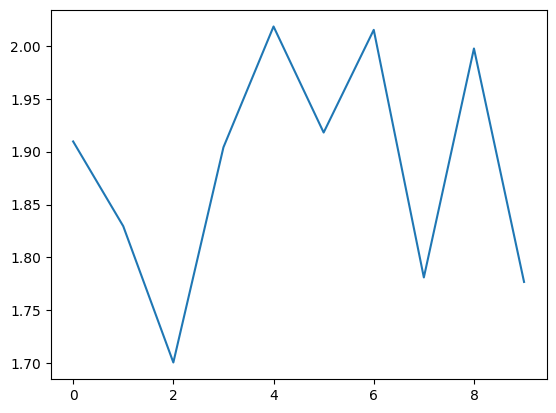

In [ ]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(losses['loss'][1]))],losses['loss'][1])

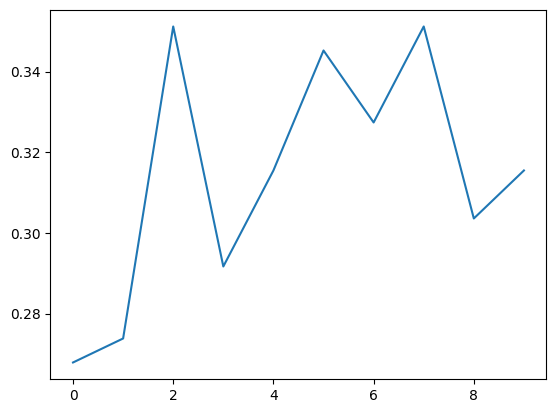

In [ ]:
plt.plot([i for i in range(len(losses['acc'][1]))],losses['acc'][1])

In [ ]:
model.save('/content/drive/MyDrive/Speech_Emotion/temporal/model.h5')

In [ ]:
def predict(test_x,labels,loss_fn,model):
  pred=model(test_x)
  loss = loss_fn(from_logits=False)(labels, pred)
  return loss,np.argmax(np.array(pred),axis=1)

In [ ]:
loss,pred_labels=predict(test_x,test_y,loss_fn,model)

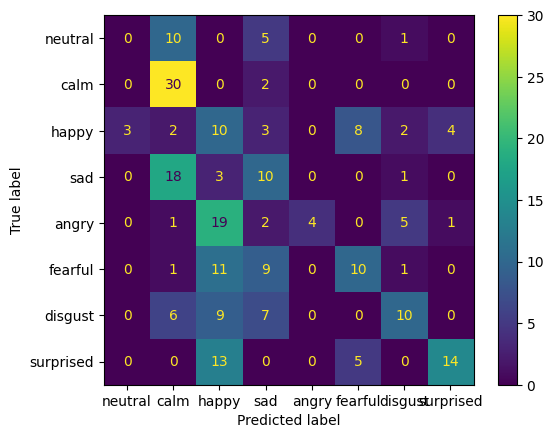

In [ ]:
predictins=[id2label[i] for i in pred_labels]
ground_truth=[id2label[i] for i in test_y]
labels=[key for key in label2id.keys()]
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(ground_truth,predictins,labels=labels)
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf,display_labels=labels)
disp.plot()

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have true labels (y_true) and predicted labels (y_pred)
# y_true and y_pred should be 1D arrays or lists

# Compute classification report
report = classification_report(ground_truth,predictins)

# Print the report
print(report)

              precision    recall  f1-score   support

       angry       1.00      0.12      0.22        32
        calm       0.44      0.94      0.60        32
     disgust       0.50      0.31      0.38        32
     fearful       0.43      0.31      0.36        32
       happy       0.15      0.31      0.21        32
     neutral       0.00      0.00      0.00        16
         sad       0.26      0.31      0.29        32
   surprised       0.74      0.44      0.55        32

    accuracy                           0.37       240
   macro avg       0.44      0.34      0.33       240
weighted avg       0.47      0.37      0.35       240

